# **Modelo de machine learning para la detección oportuna de cáncer de mama**

El diagnostico tradicional del cáncer se mama, anteriormente, se realizaba por medio de un procedimiento quirurgico. La biopsia por aspiración con aguja fina (FNA, por sus siglás en inglés, Fine Needle Aspiration) es una forma de examinar pequeñas cantidades de tejido del tumor.

Estas son examinadas para obtener las caracteristicas de las celulas individuales y propiedades contextuales importantes, tales como el tamaño de los grumos de la celula. Analizando estas caracteristicas, se ha logrado diagnosticar de forma exitosa usando la biopsia por aspiración con aguja fina.

Inicialmente, se logran identificar las caracteristicas que se consideran están relacionadas con el padecimiento, las mismas son determinadas en base a la experiencia del medico. El procedimiento de identificación de caracteristicas incluye:

1. Preparación de la imagen obtenida a partir de un pequeño fluido del tumor de mama usando una aguja fina
2. Aproximar una localización precisa de los limites de cada celula.
3. Determinar limites del nucleo de las celulas.
4. Extraer caracteristicas de los limites de cada celula.

A partir de este proceso, 10 caracteristicas son modeladas numericamente.

**Radio**: el radio de un nucleo individual es medido promediando la longitud de la linea del segmento radial definido por centroide del limite y los puntos individuales del limite.

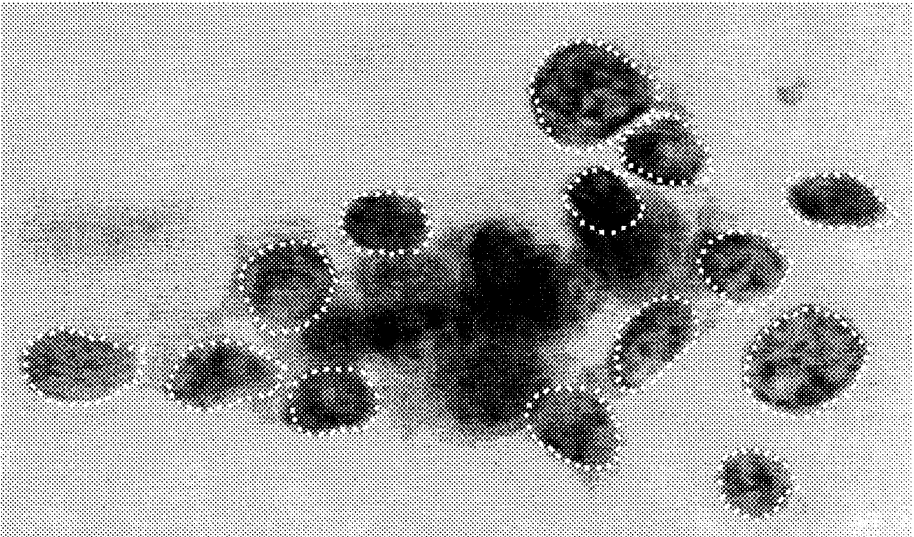

**Perimetro**: es la distancia total entre los puntos del limite constituyen el perimetro nuclear.

**Area**: se mide contando el numero de pixeles en el interior de los limites y se añade la mitad de los píxeles del perímetro.

**Compacidad**: el perimetro y el area son combinados para dar una medida de la compacidad del nucleo de la celula usando la formula: \begin{equation*}perimetro^2 / area \end{equation*}

**Suavidad**: la suavidad del contorno nuclear es cuantificable midiendo la diferencia entre la longitud de una linea radial y la longitud media de las lineas alrededor de esta.

**Concavidad**: 

**Puntos cóncavos**:

**Simetría**:

**Dimensión fractal**:

**Texture**:

El valor medio, extremo (el mas largo) y el error estandard de cada caracteristica son computados para cada imagen. Los valores extremos son mas intuitivamente utiles para el problema en question, ya que solo algunas celulas malignas pueden ocurrir en un ejemplo dado.

### Procesamiento de los datos

#### Importamos las librerias y los datos a utilizar

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#datos_cancer = pd.read_csv('/content/drive/MyDrive/Monografia - Profesor Narciso/Primeras Exploraciones/data.csv')
datos_cancer = pd.read_csv('/kaggle/input/breast-cancer-wisconsin-data/data.csv')

### Exploración de datos

#### Datos generales del conjunto de datos

In [ ]:
#Todas las caracteristicas del conjunto de datos
datos_cancer.columns

In [ ]:
#Vista previa del conjunto de datos
datos_cancer.head()

In [ ]:
# Estadisticas generales de las caracteristicas del conjunto de datos
datos_cancer.describe()

In [ ]:
# Revisión del tipo de dato por cada columna
datos_cancer.dtypes

In [ ]:
# Obtener datos 'N/A' o nulos
datos_na = datos_cancer.isna().sum()
datos_nulos = datos_cancer.isnull().sum()
validacion_datos_cancer = pd.DataFrame(data={'datos_na':datos_na, 'datos_nulos':datos_nulos})
validacion_datos_cancer = validacion_datos_cancer[
    (validacion_datos_cancer['datos_na'] > 0) | 
    (validacion_datos_cancer['datos_nulos'] > 0)
]
print(validacion_datos_cancer)

Con el codigo anterior se detectaron las columnas con valores vacios o faltantes que nos puedan afectar en la construcción del modelo en celdas posteriores.

#### Correlación entre variables

Se mide la correlación entre las variables del conjunto de datos, para esto se exceptuaran las variables que sirven para indexar el conjunto de datos (id), variable predictiva (diagnosis) y con valores vacíos o nulos (Unnamed: 32)

In [ ]:
#matriz de correlación
datos_cancer_correlacion = datos_cancer.drop(columns=['id', 'diagnosis', 'Unnamed: 32'])
datos_cancer_correlacion.corr(method='pearson', min_periods=100)
#datos_cancer_correlacion[['radius_mean', 'area_mean']].corr(method='pearson', min_periods=100).loc['radius_mean', 'area_mean']

In [ ]:
#Midiendo correlación entre variables individuales
correlacion = 0
variable_a, variable_b, corr = [], [], []
counter = 1
for i in datos_cancer_correlacion.columns:
    for y in datos_cancer_correlacion.columns:
        if i == y:
            pass
        else:
            correlacion = datos_cancer_correlacion[[i, y]].corr(method='pearson', min_periods=10).loc[i, y]
            variable_a.append(i)
            variable_b.append(y)
            corr.append(correlacion)
            
datos_correlacion = pd.DataFrame(data={'variable_a': variable_a, 'variable_b': variable_b, 'correlacion': corr})
datos_correlacion.sort_values(by=['correlacion'], ascending=False).head(10)

#### Visualización de la cantidad de diagnosticos

In [ ]:
B, M = datos_cancer['diagnosis'].value_counts()
print('Diagnosticos benignos: {}'.format(B))
print('Diagnosticos malignos: {}'.format(M))
datos_cancer['diagnosis'].value_counts().plot.bar(rot=0, x='Diagnostico')

#### Separamos los datos pertenecientes a la media, error estandar y peor del conjunto de datos original

In [ ]:
media_datos_cancer = datos_cancer.loc[:,'radius_mean':'fractal_dimension_mean']
error_estandar_datos_cancer = datos_cancer.loc[:, 'radius_se':'fractal_dimension_se']
peor_datos_cancer = datos_cancer.loc[:, 'radius_worst':'fractal_dimension_worst']

#### Revisamos la distribución de los datos para los 3 conjuntos de datos generados anteriormente

In [ ]:
#Distribución de datos de media
fig, axs = plt.subplots( figsize=(15,8))
media_datos_cancer.hist(ax=axs)
plt.tight_layout()

In [ ]:
#Distribución de error estandar de los datos
fig, axs = plt.subplots( figsize=(15,8))
error_estandar_datos_cancer.hist(ax=axs)
plt.tight_layout()

In [ ]:
#Distribución de los peores datos
fig, axs = plt.subplots( figsize=(15,8))
peor_datos_cancer.hist(ax=axs)
plt.tight_layout()

In [ ]:
def graficar_diagrama_caja(conjunto_de_datos):
  columnas, filas = 4, 3
  conjunto_de_datos_columnas = conjunto_de_datos.columns
  contador_columnas = 0
  fig, axs = plt.subplots(columnas,filas, figsize=(15,12))
  for i in range(columnas):
    for y in range(filas):
      if contador_columnas <= 9:
        media_datos_cancer[conjunto_de_datos_columnas[contador_columnas]].plot.box(ax=axs[i,y])
        contador_columnas += 1
      else:
        axs[i, y].set_visible(False)
  fig.tight_layout(pad=3.0)

#### Muestra de la dispersión de los datos y datos atipicos por medio  de un grafico de caja

In [ ]:
#Viendo la distribucion de datos atipicos por medio de un grafico de caja
graficar_diagrama_caja(media_datos_cancer)

# Modelo de aprendizaje automatico

Para la creación del modelo de aprendizaje, inicialmente se remueven las variables que se utilizaran para el desarollo del modelo. Estas variables son: diagnosis, id y Unnamed: 32.

Utilizamos la función **train_test_split** de sklearn para dividir nuestro conjunto de datos en: datos de entrenamiento y datos de test. El resultado que nos arroja la función es una tupla con lo valores X y Y para ambos conjuntos de datos.

In [ ]:
from sklearn.model_selection import train_test_split
X = datos_cancer.drop(['diagnosis', 'id', 'Unnamed: 32'], axis=1)
y = datos_cancer['diagnosis']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

Para configurar nuestro modelo utilizamos el algoritmo **RandomForest** y lo entrenamos con los datos que separamos anteriormente.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
ml_model = RandomForestClassifier(n_estimators = 10, criterion = 'entropy',
                                  random_state = 42)
ml_model.fit(X_train, y_train)

Utilizamos los datos test para validar la precisión de nuestro modelo.

In [ ]:

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

y_pred = ml_model.predict(X_test)

print('[Precisión] Random Forest:', accuracy_score(y_test, y_pred))

print('\n[Reporte de Clasificación] Random Forest')
print( classification_report(y_test, y_pred) )